## Using Texblob library to get sentiment from tweets:

In [2]:
#Imports
import os
import requests
import json 
from dotenv import load_dotenv
import tweepy
load_dotenv()
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [3]:
#twitter API keys
twitter_api_key = os.getenv("TWITTER_API_KEY")
twitter_secret_key = os.getenv("TWITTER_SECRET_KEY")
twitter_access_token = os.getenv("TWITTER_ACCESS_TOKEN")
twitter_secret_token = os.getenv("TWITTER_SECRET_TOKEN")

In [4]:
#Authorize twitter use with account
def oAuth():
    try:
        auth = tweepy.OAuthHandler(twitter_api_key,twitter_secret_key)
        auth.set_access_token(twitter_access_token,twitter_secret_token)
        return auth
    except Exception as e:
        return None

oauth= oAuth()

#set twitter api object 
twitter_api = tweepy.API(oauth)

In [5]:
#Gather 2000 tweets - BTC
search_term = 'bitcoin' + '-filter:retweets'
#create a cursor object
#twitterapi.search_tweets has been most consistent with filtering retweets and getting hundreds of tweets without using twitter data website storage
tweets = tweepy.Cursor(twitter_api.search_tweets, q=search_term, tweet_mode = 'extended', lang = 'en').items(200)

In [6]:
#gather text from tweets
all_tweets = [tweet.full_text for tweet in tweets]

In [7]:
#create df for tweets
df = pd.DataFrame(all_tweets, columns=['Tweets'])
df.head()

,Tweets
0,#Bitcoin stats every hour\n----\nBlock: 778542...
1,"THETA, LIDO, KLAY and EGLD flash bullish signs..."
2,BITCOIN PAYMENTS = DISCOUNT 🏆 https://t.co/BCd...
3,Crypto Market Update 2023-02-27 (1/3)\n📈 Total...
4,"Feb 27, 2023 10:00AM #Bitcoin Price:\nUSD 2353..."


In [8]:
#Function to try and clean up some of the noise in the tweets
def cleanTwt(twt):
    twt = re.sub('#bitcoin','bitcoin', twt)
    twt = re.sub('#Bitcoin','Bitcoin', twt)
    twt = re.sub('#[A-Za-z0-9]+', '', twt)
    twt = re.sub('\\n', '', twt)
    twt = re.sub('https?:\/\/\S+','', twt) #removes https links
    return twt

In [9]:
df['Clean_Tweets'] = df['Tweets'].apply(cleanTwt)
df.head()

,Tweets,Clean_Tweets
0,#Bitcoin stats every hour\n----\nBlock: 778542...,Bitcoin stats every hour----Block: 778542Hashr...
1,"THETA, LIDO, KLAY and EGLD flash bullish signs...","THETA, LIDO, KLAY and EGLD flash bullish signs..."
2,BITCOIN PAYMENTS = DISCOUNT 🏆 https://t.co/BCd...,BITCOIN PAYMENTS = DISCOUNT 🏆
3,Crypto Market Update 2023-02-27 (1/3)\n📈 Total...,Crypto Market Update 2023-02-27 (1/3)📈 Total M...
4,"Feb 27, 2023 10:00AM #Bitcoin Price:\nUSD 2353...","Feb 27, 2023 10:00AM Bitcoin Price:USD 23532.5..."


In [10]:
#get subjectivity and polarity using textblob library

def getSubjectivity(twt):
    return TextBlob(twt).sentiment.subjectivity

def getPolarity(twt):
    return TextBlob(twt).sentiment.polarity

df['subjectivity'] = df['Clean_Tweets'].apply(getSubjectivity)
df['polarity'] = df['Clean_Tweets'].apply(getPolarity)

In [11]:
#Sentiment function to determine the pos/neg tweets using their polarity scores

def getsentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Sentiment'] = df['polarity'].apply(getsentiment)

In [12]:
positive=[]
negative=[]
neutral=[]

#polarity > 0 == positive 

for polarity in df['polarity']:
    if polarity > 0:
        positive.append(polarity)
    elif polarity == 0:
        neutral.append(polarity)
    else:
        negative.append(polarity)


print(f"Positive: {len(positive)}")
print(f"Neutral: {len(neutral)}")
print(f"Negative: {len(negative)}")

Positive: 89
Neutral: 86
Negative: 25


In [13]:
df

,Tweets,Clean_Tweets,subjectivity,polarity,Sentiment
0,#Bitcoin stats every hour\n----\nBlock: 778542...,Bitcoin stats every hour----Block: 778542Hashr...,0.066667,0.0,Neutral
1,"THETA, LIDO, KLAY and EGLD flash bullish signs...","THETA, LIDO, KLAY and EGLD flash bullish signs...",0.000000,0.0,Neutral
2,BITCOIN PAYMENTS = DISCOUNT 🏆 https://t.co/BCd...,BITCOIN PAYMENTS = DISCOUNT 🏆,0.000000,0.0,Neutral
3,Crypto Market Update 2023-02-27 (1/3)\n📈 Total...,Crypto Market Update 2023-02-27 (1/3)📈 Total M...,0.750000,0.0,Neutral
4,"Feb 27, 2023 10:00AM #Bitcoin Price:\nUSD 2353...","Feb 27, 2023 10:00AM Bitcoin Price:USD 23532.5...",0.000000,0.0,Neutral
...,...,...,...,...,...
195,XRP Lawyer Exposes History Behind Gary Gensler...,XRP Lawyer Exposes History Behind Gary Gensler...,0.700000,-0.4,Negative
196,Argo Class Action: Levi &amp; Korsinsky Remind...,Argo Class Action: Levi &amp; Korsinsky Remind...,0.100000,0.1,Positive
197,"Bitcoin, Ethereum Price Prediction: Is The Ong...","Bitcoin, Ethereum Price Prediction: Is The Ong...",0.000000,0.0,Neutral
198,#BinanceCoin price update: $BNB\n\n#BNB $303.7...,price update: $BNB $303.77 USDBitcoin 0.01301...,0.250000,0.0,Neutral


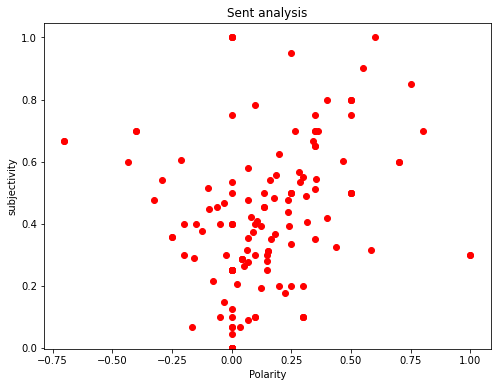

In [14]:
#The higher subjectivity means that the text contains personal opinion rather than factual information
#Higher polarity means more positive sentiment and vise-versa

plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
    plt.scatter(df['polarity'][i], df['subjectivity'][i], color = 'red')
plt.title('Sent analysis')
plt.xlabel('Polarity')
plt.ylabel('subjectivity')
plt.show()